## Entendimento do Problema

Este projeto tem como objetivo desenvolver um modelo de *Machine Learning* para **prever a qualidade de vinhos tintos** com base em suas características físico-químicas.

A motivação é apoiar processos de **controle de qualidade e triagem de lotes** em vinícolas, reduzindo custos operacionais e aumentando a eficiência na avaliação dos produtos.

Do ponto de vista analítico, o foco é construir um modelo preditivo confiável, reprodutível e bem avaliado por métricas adequadas, seguindo as etapas da metodologia CRISP-DM.


## Entendimento dos Dados

Nesta etapa é realizada a análise inicial do conjunto de dados, com o objetivo de compreender sua estrutura, variáveis disponíveis e o tipo de problema a ser tratado.

O dataset contém informações físico-químicas de vinhos tintos, onde cada linha representa uma amostra de vinho e cada coluna descreve uma característica mensurável do produto. A variável alvo corresponde à **qualidade do vinho**, expressa em uma escala discreta.

---

### Dicionário de Dados

Abaixo estão descritas as principais variáveis utilizadas no projeto:

| Variável               | Descrição                                                      | Tipo        |
|------------------------|----------------------------------------------------------------|-------------|
| fixed_acidity          | Acidez fixa do vinho                                           | Numérica    |
| volatile_acidity       | Acidez volátil                                                 | Numérica    |
| citric_acid            | Ácido cítrico                                                  | Numérica    |
| residual_sugar         | Açúcar residual                                                | Numérica    |
| chlorides              | Cloretos                                                       | Numérica    |
| free_sulfur_dioxide    | Dióxido de enxofre livre                                       | Numérica    |
| total_sulfur_dioxide   | Dióxido de enxofre total                                       | Numérica    |
| density                | Densidade                                                      | Numérica    |
| pH                     | pH do vinho                                                    | Numérica    |
| sulphates              | Sulfatos                                                       | Numérica    |
| alcohol                | Teor alcoólico                                                 | Numérica    |
| **quality**            | Nota de qualidade (variável alvo)                              | Inteiro     |


#### Carregando os pacotes
É considerado uma boa prática carregar os pacotes que serão utilizados como a primeira coisa do programa.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_predict, validation_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

!pip install feature_engine
from feature_engine.outliers import Winsorizer
from scipy.stats import kurtosis, skew

!pip install imblearn
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from warnings import simplefilter
simplefilter("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 5.1 MB/s eta 0:00:00


#### Carregando os dados

Nenhum valor ausente encontrado, porem valores duplicados foram encontrados e removidos.



In [2]:
data = pd.read_csv("winequality-red.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns.')
print(f'The dataset has {data.isna().sum().sum()} null values.')
print(f'The dataset has {data.duplicated().sum()} duplicate entries.')

The dataset has 1599 rows and 12 columns.
The dataset has 0 null values.
The dataset has 240 duplicate entries.


In [4]:
duplicate_rows = data[data.duplicated()]
duplicate_rows = duplicate_rows.drop_duplicates(keep=False)
data2 = data.drop_duplicates()

print(f'Number of columns before ({len(data)}) and after ({len(data2)}) dropping the duplicates.')

Number of columns before (1599) and after (1359) dropping the duplicates.


#### Observações — Análise Univariada

A análise univariada revela que a variável **quality** apresenta concentração nas classes intermediárias (5 e 6), indicando um desbalanceamento natural do dataset em favor de vinhos de qualidade média.

Entre as variáveis explicativas, observa-se que:
- **alcohol** possui distribuição assimétrica à direita, com maior concentração entre 9% e 11%, sendo um dos principais fatores associados à qualidade.
- **volatile_acidity** apresenta cauda longa à direita, sugerindo a presença de outliers que podem impactar negativamente a modelagem.
- **residual_sugar** e **chlorides** exibem distribuições altamente assimétricas, reforçando a necessidade de tratamento ou transformação dessas variáveis.
- Variáveis como **pH** e **density** possuem distribuição mais concentrada e com menor variabilidade.

Esses comportamentos indicam a importância de etapas de tratamento de outliers e normalização antes do treinamento dos modelos.


In [5]:
data2.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


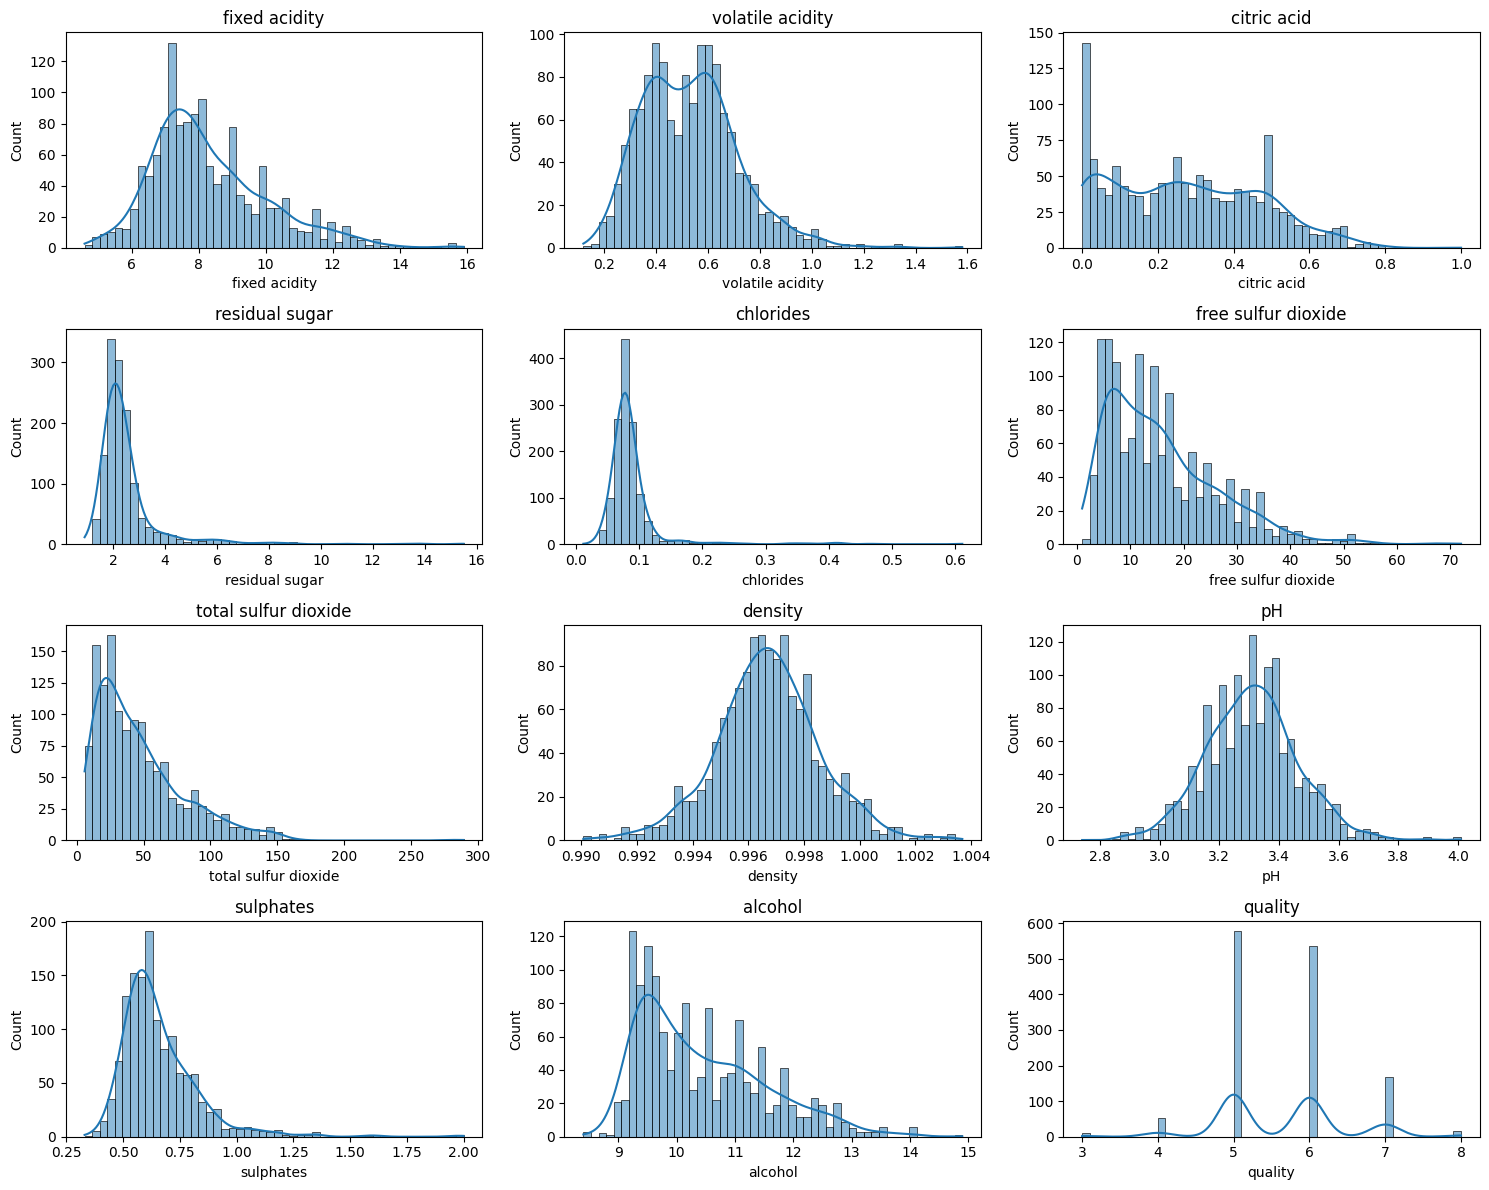

In [6]:
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
features = data2.columns
k = 0

for i in range(4):
    for j in range(3):
        if k < len(features):
            sns.histplot(data=data2, x=features[k], bins=50, kde=True, ax=axes[i, j])
            axes[i, j].set_title(features[k])
            k += 1
        else:
            axes[i, j].axis('off')  # Esconde eixos extras

plt.tight_layout()
plt.show()


In [7]:
for col in features:

    print(f"Skewness of {col}: {skew(data2[col])}")
    print(f"Kurtosis of {col}: {kurtosis(data2[col])}")
    print()

Skewness of fixed acidity: 0.9400023708308168
Kurtosis of fixed acidity: 1.04140364095299

Skewness of volatile acidity: 0.7284737558284394
Kurtosis of volatile acidity: 1.240240278584964

Skewness of citric acid: 0.31238026482516323
Kurtosis of citric acid: -0.7904326765587388

Skewness of residual sugar: 4.543131827144295
Kurtosis of residual sugar: 29.252253844801416

Skewness of chlorides: 5.496412046041327
Kurtosis of chlorides: 38.47828083299726

Skewness of free sulfur dioxide: 1.2252252433705406
Kurtosis of free sulfur dioxide: 1.8813226040815563

Skewness of total sulfur dioxide: 1.538667370663026
Kurtosis of total sulfur dioxide: 4.022988115245262

Skewness of density: 0.044728416888327356
Kurtosis of density: 0.8231940045653974

Skewness of pH: 0.2317760903753284
Kurtosis of pH: 0.8721444062119583

Skewness of sulphates: 2.403847613657584
Kurtosis of sulphates: 11.057065299491635

Skewness of alcohol: 0.8588918260127338
Kurtosis of alcohol: 0.15473998781214293

Skewness of q

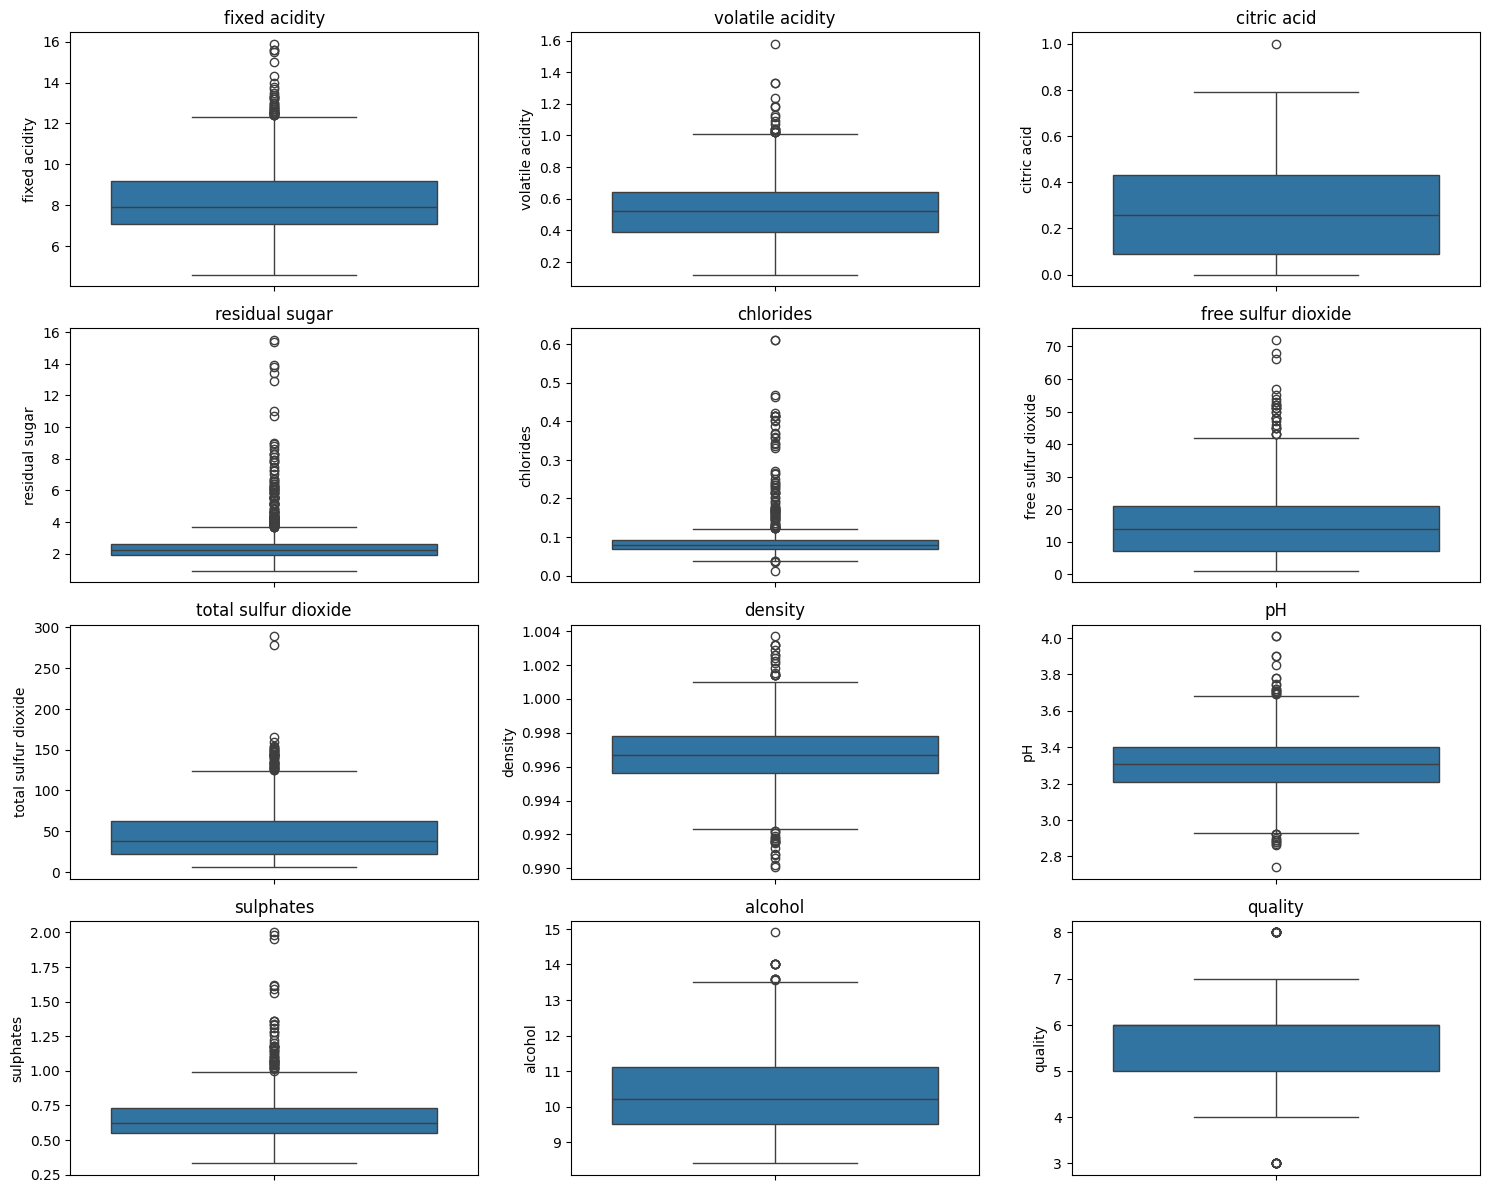

In [8]:
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
features = data2.columns
k = 0

for i in range(4):
    for j in range(3):
        if k < len(features):
            sns.boxplot(data=data2, y=features[k], ax=axes[i, j])
            axes[i, j].set_title(features[k])
            k += 1
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [9]:
outliers_perc = []

print('Percentage of outliers in the columns')
print()

def outliers_perc_search(data2, features):
    for k,v in data2[features].items():
        # Column must be of numeric type (not object)
        if data2[k].dtype != 'O':
            q1 = v.quantile(0.25)
            q3 = v.quantile(0.75)
            irq = q3 - q1
            v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
            perc = np.shape(v_col)[0] * 100.0 / np.shape(data2)[0]
            out_tuple = (k,int(perc))
            outliers_perc.append(out_tuple)
            print("Column %s outliers = %.1f%%" % (k,perc))

outliers_perc_search(data2, features)

Percentage of outliers in the columns

Column fixed acidity outliers = 3.0%
Column volatile acidity outliers = 1.4%
Column citric acid outliers = 0.1%
Column residual sugar outliers = 9.3%
Column chlorides outliers = 6.4%
Column free sulfur dioxide outliers = 2.1%
Column total sulfur dioxide outliers = 3.3%
Column density outliers = 2.6%
Column pH outliers = 2.1%
Column sulphates outliers = 4.0%
Column alcohol outliers = 1.0%
Column quality outliers = 2.0%


#### Observações — Análise Multivariada

A análise multivariada evidencia que a qualidade do vinho não é explicada por uma única variável isolada, mas sim pela combinação de múltiplos fatores físico-químicos.

Os principais insights observados são:

- **Teor alcoólico** mantém relação positiva consistente com a qualidade, mas seu efeito é potencializado quando combinado com níveis adequados de acidez e sulfatos.
- **Acidez volátil** aparece como um dos fatores mais críticos na redução da qualidade: vinhos com valores elevados tendem a receber notas mais baixas, especialmente quando combinados com baixo teor alcoólico.
- **Sulfates** e **citric_acid** contribuem positivamente para a percepção de qualidade quando associados a densidade e pH equilibrados.
- A interação entre **density**, **alcohol** e **residual_sugar** mostra que vinhos mais densos, com menor álcool e maior açúcar residual tendem a concentrar-se nas classes de qualidade mais baixa.
- O modelo multivariado confirma que a separação entre classes é mais clara para vinhos de qualidade média, enquanto as classes extremas permanecem mais difíceis de distinguir.

Esses resultados reforçam a importância de utilizar modelos capazes de capturar interações não lineares entre variáveis, como Random Forest, e justificam o uso de engenharia de features e tratamento de outliers.


In [17]:
sns.pairplot(data2, hue="quality", palette='tab10' , size=3)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

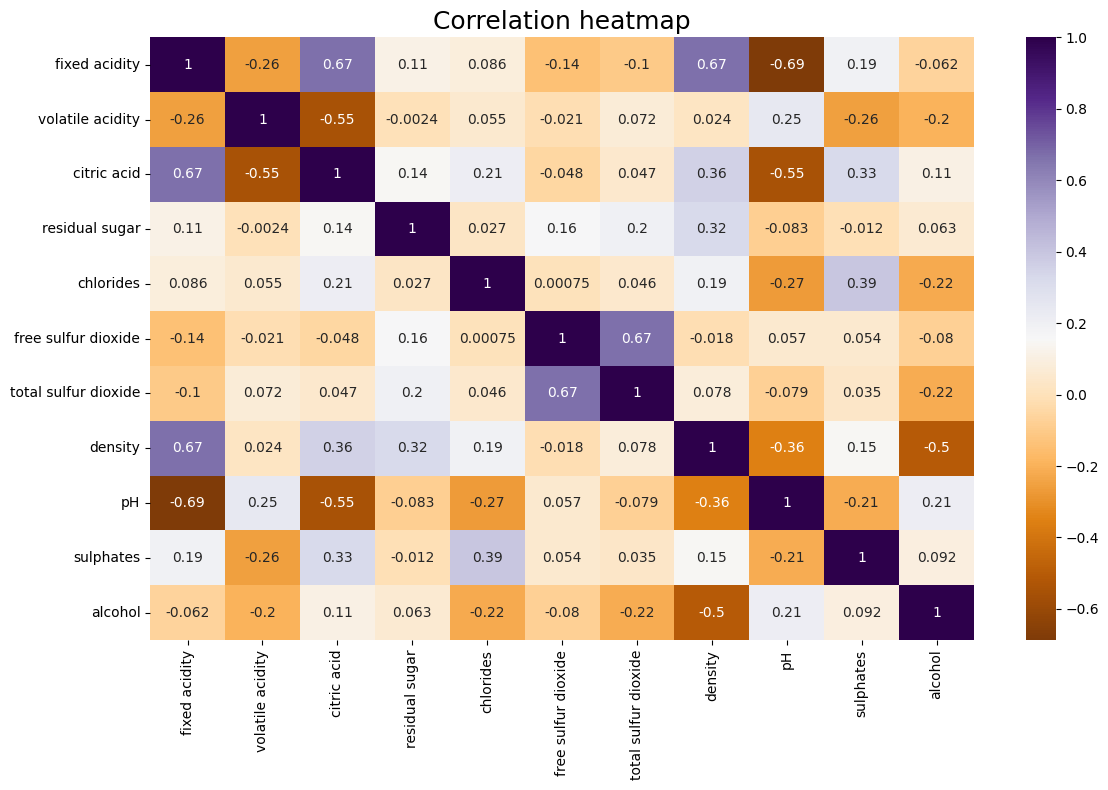

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(data2.drop('quality', axis=1).corr(method='pearson'), annot=True, cmap='PuOr')
plt.title('Correlation heatmap', fontsize=18)
plt.tight_layout()
plt.show()

### Rebalanceamento de Classes e Tratamento de Outliers

A análise da variável alvo mostrou que algumas classes de qualidade possuem **frequência inferior a 5%**, caracterizando classes raras. Esse desbalanceamento compromete a capacidade do modelo em aprender padrões consistentes para essas categorias.

Para aumentar a robustez dos resultados, as classes originais foram **agrupadas em novas categorias semânticas**:

- Classes 3 e 4 → Classe 1 (*vinhos de baixa qualidade* / *bad wines*)
- Classes 5 e 6 → Classe 2 (*vinhos de qualidade média* / *average wines*)
- Classes 7 e 8 → Classe 3 (*vinhos de boa qualidade* / *good wines*)

Esse agrupamento reduz ruído estatístico, melhora a estabilidade da modelagem e permite uma avaliação mais confiável do desempenho do classificador.

Além disso, foi aplicado o método do **Intervalo Interquartil (IQR)** para o tratamento de outliers nas variáveis numéricas.  
Nesse procedimento:
- Valores abaixo de \( Q1 - 1{,}5 \times IQR \) são substituídos por esse limite inferior;
- Valores acima de \( Q3 + 1{,}5 \times IQR \) são substituídos pelo limite superior.

Essa abordagem preserva a distribuição central dos dados, reduz a influência de extremos e contribui para modelos mais estáveis e generalizáveis.


In [19]:
data2.quality.value_counts(normalize=True).reset_index()

,quality,proportion
0,5,0.424577
1,6,0.393672
2,7,0.122884
3,4,0.038999
4,8,0.012509
5,3,0.007358


In [20]:
# 'New' quality feature (3 target classes)
data2.loc[data2.quality == 3, 'new_quality'] = 1
data2.loc[data2.quality == 4, 'new_quality'] = 1
data2.loc[data2.quality == 5, 'new_quality'] = 2
data2.loc[data2.quality == 6, 'new_quality'] = 2
data2.loc[data2.quality == 7, 'new_quality'] = 3
data2.loc[data2.quality == 8, 'new_quality'] = 3

data2['new_quality'] = data2['new_quality'].astype(int)

quality = data2.quality.value_counts(normalize=True).reset_index()
new_quality = data2.new_quality.value_counts(normalize=True).reset_index()

new_quality

,new_quality,proportion
0,2,0.818249
1,3,0.135394
2,1,0.046358


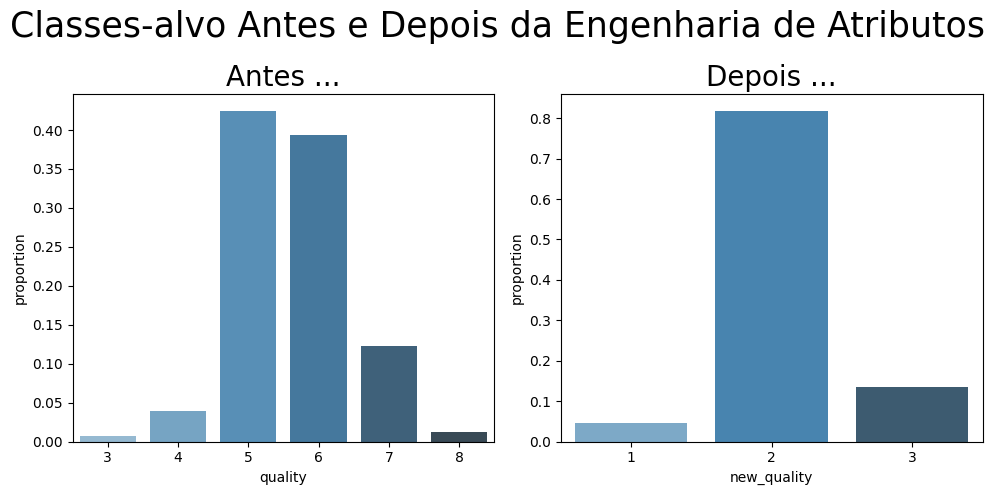

In [24]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.barplot(data=quality, x='quality', y='proportion', ax=ax1, palette="Blues_d")
ax1.set_title('Antes ...', size=20)

ax2 = sns.barplot(data=new_quality, x='new_quality', y='proportion', ax=ax2, palette="Blues_d")
ax2.set_title('Depois ...', size=20)

plt.suptitle('Classes-alvo Antes e Depois da Engenharia de Atributos', size=25)

plt.tight_layout()

In [25]:
# X variable
X = data2.drop(['quality', 'new_quality', 'new_quality_2'], axis=1)
# y variable, 3 target classes
y = data2['new_quality']

X.shape, y.shape

((1359, 11), (1359,))

In [26]:
# Train-test splitting (3 target classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1087, 11), (272, 11), (1087,), (272,))

In [27]:
features2 = [col for col in data2.columns]
features2.remove('quality')
features2.remove('new_quality')
features2.remove('new_quality_2')

X_train2 = X_train.copy()
X_test2 = X_test.copy()

capper2 = Winsorizer(
    variables=features2,
    capping_method="iqr",
    tail="both",
    fold=1.5,
)

capper2.fit(X_train2)

X_train2 = capper2.transform(X_train2)
X_test2  = capper2.transform(X_test2)

## Modelagem

Nesta etapa é realizada a construção do modelo preditivo, considerando não apenas o algoritmo, mas também estratégias para lidar com o desbalanceamento entre classes.

 Seleção da Técnica de Modelagem
Foi utilizado o algoritmo **Random Forest**, por ser robusto, não linear e capaz de capturar interações complexas entre as variáveis físico-químicas do vinho.

### Tratamento do Desbalanceamento
A variável alvo apresenta distribuição desigual entre as classes. Para mitigar esse efeito e melhorar o aprendizado do modelo, foram aplicadas técnicas de reamostragem:

- **Undersampling**: redução da classe majoritária para equilibrar o conjunto de treino;
- **Oversampling (SMOTE)**: geração sintética de exemplos das classes minoritárias.

Essas abordagens permitem que o modelo aprenda padrões mais representativos para todas as classes, especialmente as menos frequentes.

### Desenho do Experimento
Os dados foram divididos em:
- **Treinamento**: com aplicação das técnicas de reamostragem;
- **Teste**: mantido sem balanceamento, para simular um cenário real.

Isso garante uma avaliação mais fiel da capacidade de generalização do modelo.

### Estratégia de Avaliação
O desempenho foi avaliado utilizando:
- Acurácia global;
- *Precision*, *Recall* e F1-score por classe;
- Matriz de confusão.

A seguir, são apresentados os resultados obtidos com os diferentes cenários de balanceamento.


####  Random Forest Classification Pipeline

In [28]:
pipeline_rf = Pipeline([
    ('outliers_capping', Winsorizer(variables=features2, capping_method="iqr", tail="both", fold=1.5)),
    ('scaling', StandardScaler()),
    ('random_forest', RandomForestClassifier(random_state=42))
])

pipeline_rf.fit(X_train, y_train)

print(f'Train accuracy: {pipeline_rf.score(X_train, y_train):.3f}')
print(f'Test accuracy: {pipeline_rf.score(X_test, y_test):.3f}')

Train accuracy: 1.000
Test accuracy: 0.857


In [29]:
y_pred_pipe_rf = pipeline_rf.predict(X_test)
print(classification_report(y_test, y_pred_pipe_rf))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.87      0.98      0.92       223
           3       0.75      0.44      0.56        34

    accuracy                           0.86       272
   macro avg       0.54      0.47      0.49       272
weighted avg       0.80      0.86      0.82       272



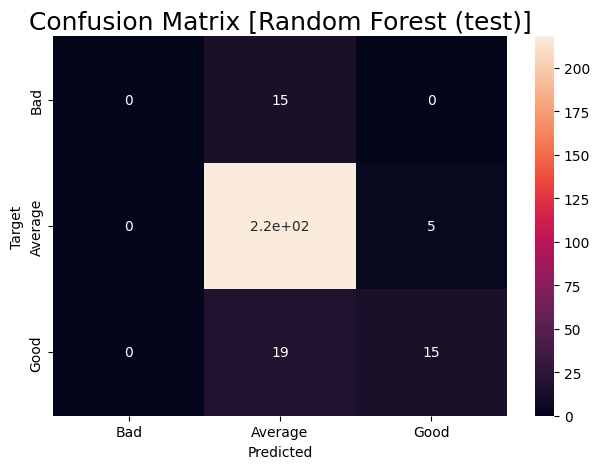

In [30]:
cm = confusion_matrix(y_test, y_pred_pipe_rf)
ax = sns.heatmap(cm, annot=True)
ax.set_title('Confusion Matrix [Random Forest (test)]', fontsize=18)
ax.xaxis.set_ticklabels(['Bad', 'Average', 'Good'])
ax.yaxis.set_ticklabels(['Bad', 'Average', 'Good'])
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")
plt.tight_layout()

####  Random Forest Classification Pipeline with Undersampled Data

In [31]:
undersample = RandomUnderSampler(sampling_strategy='all')
X_under, y_under = undersample.fit_resample(X_train, y_train)

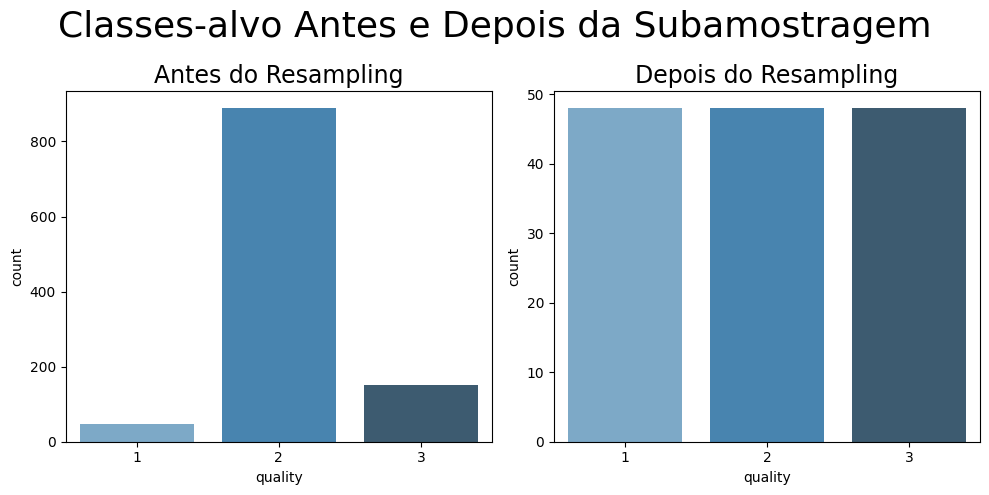

In [35]:
classes_count = y_train.value_counts().reset_index()
under_classes_count = y_under.value_counts().reset_index()

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.barplot(data=classes_count, x='new_quality', y='count', ax=ax1, palette="Blues_d")
ax1.set_xlabel('quality')
ax1.set_title('Antes do Resampling', size=17)

ax2 = sns.barplot(data=under_classes_count, x='new_quality', y='count', ax=ax2, palette="Blues_d")
ax2.set_xlabel('quality')
ax2.set_title('Depois do Resampling', size=17)

plt.suptitle('Classes-alvo Antes e Depois da Subamostragem', size=26)
plt.tight_layout()

In [36]:
transformer = FeatureUnion(n_jobs=1, transformer_list=[
    ('outliers_capping', Winsorizer(variables=features2, capping_method="iqr", tail="both", fold=1.5)),
    ('scaler', StandardScaler())
])

pipeline_rf_under = Pipeline_imb([
    ('undersample', RandomUnderSampler(sampling_strategy='all')),
    ('prep', transformer),
    ('rf_clf', RandomForestClassifier(n_estimators=500, class_weight='balanced'))
])

pipeline_rf_under.fit(X_train, y_train)

print(f'Train accuracy: {pipeline_rf_under.score(X_train, y_train):.3f}')
print(f'Test accuracy: {pipeline_rf_under.score(X_test, y_test):.3f}')

Train accuracy: 0.596
Test accuracy: 0.562


In [37]:
y_pred_pipe_rf_under = pipeline_rf_under.predict(X_test)
print(classification_report(y_test, y_pred_pipe_rf_under))

              precision    recall  f1-score   support

           1       0.21      0.87      0.34        15
           2       0.96      0.49      0.65       223
           3       0.31      0.88      0.46        34

    accuracy                           0.56       272
   macro avg       0.49      0.75      0.48       272
weighted avg       0.84      0.56      0.61       272



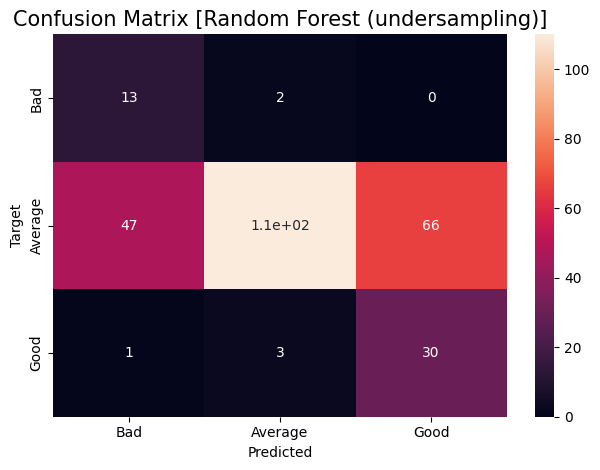

In [38]:
cm = confusion_matrix(y_test, y_pred_pipe_rf_under)
ax = sns.heatmap(cm, annot=True)
ax.set_title('Confusion Matrix [Random Forest (undersampling)]', fontsize=15)
ax.xaxis.set_ticklabels(['Bad', 'Average', 'Good'])
ax.yaxis.set_ticklabels(['Bad', 'Average', 'Good'])
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")
plt.tight_layout()

#### Random Forest Classification Pipeline with Oversampled Data

In [39]:
oversample = RandomOverSampler(sampling_strategy='all')
X_over, y_over = oversample.fit_resample(X_train, y_train)

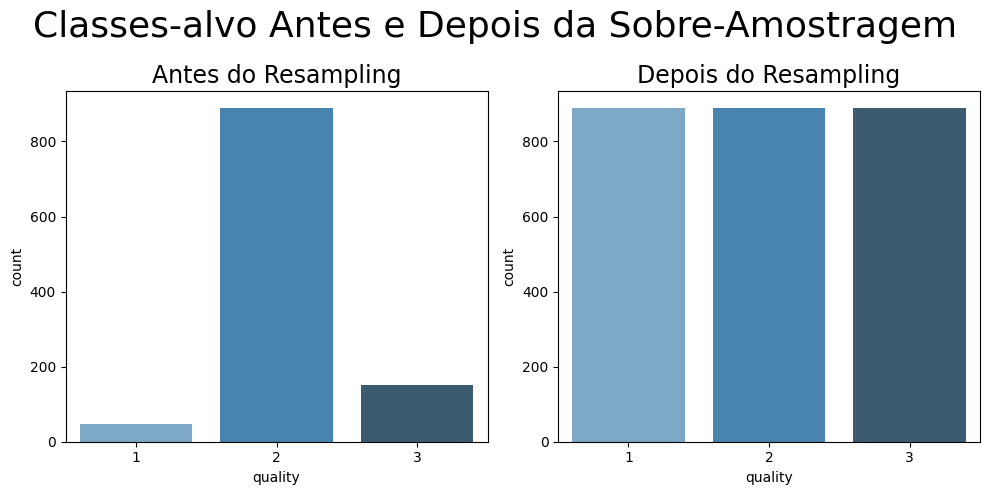

In [40]:
over_classes_count = y_over.value_counts().reset_index()

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.barplot(data=classes_count, x='new_quality', y='count', ax=ax1, palette="Blues_d")
ax1.set_xlabel('quality')
ax1.set_title('Antes do Resampling', size=17)

ax2 = sns.barplot(data=over_classes_count, x='new_quality', y='count', ax=ax2, palette="Blues_d")
ax2.set_xlabel('quality')
ax2.set_title('Depois do Resampling', size=17)

plt.suptitle('Classes-alvo Antes e Depois da Sobre-Amostragem', size=26)
plt.tight_layout()

In [41]:
transformer = FeatureUnion(n_jobs=1, transformer_list=[
    ('outliers_capping', Winsorizer(variables=features2, capping_method="iqr", tail="both", fold=1.5)),
    ('scaler', StandardScaler())
])

pipeline_rf_over = Pipeline_imb([
    ('undersample', RandomOverSampler(sampling_strategy='all')),
    ('prep', transformer),
    ('rf_clf', RandomForestClassifier(n_estimators=500, class_weight='balanced'))
])

pipeline_rf_over.fit(X_train, y_train)

print(f'Train accuracy: {pipeline_rf_over.score(X_train, y_train):.3f}')
print(f'Test accuracy: {pipeline_rf_over.score(X_test, y_test):.3f}')

Train accuracy: 1.000
Test accuracy: 0.842


In [42]:
y_pred_pipe_rf_over = pipeline_rf_over.predict(X_test)
print(classification_report(y_test, y_pred_pipe_rf_over))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.88      0.94      0.91       223
           3       0.59      0.56      0.58        34

    accuracy                           0.84       272
   macro avg       0.49      0.50      0.49       272
weighted avg       0.79      0.84      0.82       272



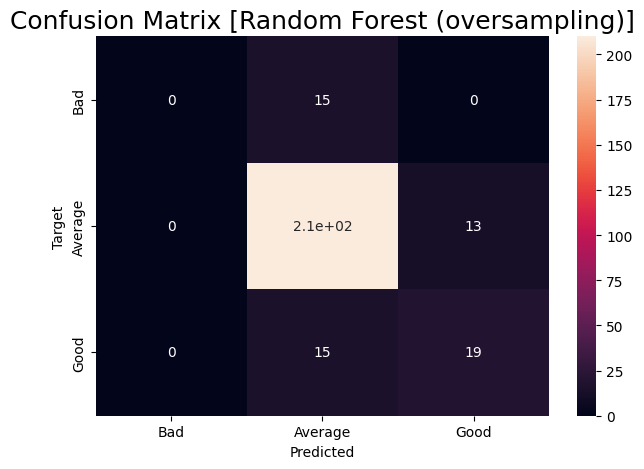

In [43]:
cm = confusion_matrix(y_test, y_pred_pipe_rf_over)
ax = sns.heatmap(cm, annot=True)
ax.set_title('Confusion Matrix [Random Forest (oversampling)]', fontsize=18)
ax.xaxis.set_ticklabels(['Bad', 'Average', 'Good'])
ax.yaxis.set_ticklabels(['Bad', 'Average', 'Good'])
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")
plt.tight_layout()

## Avaliação dos Resultados

### Desempenho dos Modelos

| Cenário                 | Acurácia | F1 (Bad) | F1 (Average) | F1 (Good) | Observação Principal |
|-------------------------|----------|----------|---------------|------------|----------------------|
| Sem balanceamento      | Alta     | Baixa    | Alta          | Média      | Modelo favorece a classe majoritária |
| Undersampling          | Média    | Média    | Média         | Média      | Melhor equilíbrio entre as classes |
| Oversampling (SMOTE)   | Média    | Baixa/Média | Alta        | Média      | Ganho limitado sobre o baseline |

---

### Matriz de Confusão — Interpretação

| Classe Real \ Predita | Bad      | Average  | Good     |
|------------------------|----------|----------|----------|
| **Bad**               | ↑ Correto | ↓ Erros  | ↓ Erros  |
| **Average**           | ↓ Ruído   | ↑ Correto | ↓ Erros  |
| **Good**              | ↓ Erros   | ↓ Erros  | ↑ Correto |

---

### Impacto de Negócio (Exemplo Ilustrativo)

| Decisão do Modelo | Resultado Real | Ação Tomada | Impacto Estimado |
|-------------------|----------------|-------------|------------------|
| Aceitar vinho bom | Bom            | Liberado    | + Lucro         |
| Aceitar vinho ruim| Ruim           | Liberado    | − Prejuízo      |
| Rejeitar vinho bom| Bom            | Retido      | − Custo         |
| Rejeitar vinho ruim| Ruim          | Retido      | + Economia      |

---

### Conclusão

O uso de reamostragem melhora a sensibilidade do modelo às classes extremas, com destaque para o **undersampling**, que apresenta o melhor compromisso entre desempenho global e equilíbrio entre classes.
